# Gradient Boosting

In this notebook, you will learn Gradient Boosting for classification; AdaBoost is a particular case of Gradient Boosting and an additive model where we add weak learners to minimize the loss function. This lab will focus on **XGBoost**, an open-source software library that provides a regularizing gradient boosting framework.  XGBoost can use different types of weak learners called boosters for classification and regression. We will focus on trees for classification.


Unlike Bagging and Random Forest, Gradient Boosting can cause overfitting. As a result, Gradient Boosting requires Hyperparameter tuning, taking more time to train. One advantage of Gradient Boosting is that each classifier is smaller, so predictions are faster in Gradient Boosting.
AdaBoost is a subclass of Gradient Boosting; one weakness of AdaBoost is that misclassified samples cause overfitting; Gradient Boosting uses different loss functions, reducing this effect.

## **Table of Contents**

​

<!-- <a href="#Multi-Dimensional_Scaling">Multi-Dimensional Scaling/a> -->

<ol>
<li style="list-style-type: none;">
<ol>
<li>Objectives</li>
<li>Setup
<ol>
<li>Installing Required Libraries&lt;</li>
<li>Importing Required Libraries</li>
<li>Defining Helper Functions</li>
</ol>
</li>
<li>How  Gradient Boosting  Works
    <ol>
    <li> How to Minimize Cost</li>
    <li>  Example with Python </li>
    </ol>

<li>Xgboost<br />
<ol>
<li>About the dataset</li>
<li>Gradient Boosting parameter</li>
 <li>Evaluation Metric on Second Dataset </li>
    <li>Early Stopping </li>
    <li>Parameters for Trees </li>

</ol>
</li>
<li>Cancer Data Example with GridSearchCV</li>
<li>Practice</li>
</ol>
</li>
</ol>


## Objectives

*   Understand   Gradient Boosting  is a linear combination of  𝑇 weak classifiers
*   Apply Gradient Boosting using  XGBoost,
*   Understand Hyperparameters selection in  XGBoost


In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

Ignore error warnings.


In [2]:
import warnings
warnings.filterwarnings('ignore')

This function will calculate the accuracy of the training and testing data given a model.


In [3]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

This function calculates the average accuracy of differnt learning rates on training and test data.


In [4]:
def get_accuracy_boost(X,y,title,times=20,xlabel='Number Estimators',Learning_rate_=[0.2,0.4,0.6,1], n_est = 100):

    lines_array=['solid','--', '-.', ':']

    N_estimators=[n*2 for n in range(1,n_est//2)]
    
    train_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))
    test_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))


    #Iterate through different number of Learning rate  and average out the results  
    
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            for j,lr in enumerate(Learning_rate_):


                model = XGBClassifier(objective=objective,learning_rate=lr,n_estimators=n_estimators,eval_metric='mlogloss')


                model.fit(X_train,y_train)



                Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  model)



                train_acc[n,j,(n_estimators//2)-1]=Accuracy['train Accuracy']
                test_acc[n,j,(n_estimators//2)-1]=Accuracy['test Accuracy']
    



    fig, ax1 = plt.subplots()
    mean_test=test_acc.mean(axis=0)
    mean_train=train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j,(lr,line) in enumerate(zip(Learning_rate_,lines_array)): 

        ax1.plot(mean_train[j,:],linestyle = line,color='b',label="Learning rate "+str(lr))
        ax2.plot(mean_test[j,:],linestyle = line, color='r',label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    ax1.set_xlabel(xlabel)
    plt.show()

# Xgboost


### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than to acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


Load Data From CSV File.


In [5]:
churn_df = pd.read_csv("ChurnData.csv")

churn_df.head()

,Unnamed: 0,tenure,age,address,income,ed,employ,equip,callcard,wireless,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


### Data pre-processing and selection


Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [6]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


#### Select Variables at Random


Like Bagging RF uses, an independent bootstrap sample from the training data. In addition, we select $m$ variables at random out of all $M$ possible
variables. Let's do an example.


In [7]:
X=churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]

There are 7 features.


#### Train/Test dataset


Let's define X, and y for our dataset:


In [8]:
y = churn_df['churn']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int32

#### Train/Test dataset


We split our dataset into train and test set:


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (140, 7) (140,)
Test set (60, 7) (60,)


### Gradient Boosting parameter


We can import the XGB Classifier in XG Boost there are many parameters let's go over a few, for more info check out <a href="https://xgboost.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01"> here </a> you may need to install it:


In [10]:
from xgboost import XGBClassifier

Let's go over  parameters independent of the  estimator.


The parameter <code>n_estimators</code> Number of gradient boosted trees.  Equivalent to number of boosting rounds.


In [11]:
n_estimators=5

`random_state` Random number seed


In [12]:
random_state=0

`objective` :  Specify the learning task and the corresponding learning objective or a custom objective function to be used.
For example:

`binary:logistic`: binary classification

`multi:softprob`:multi-class classification


In [13]:
objective='binary:logistic'

`learning_rate` : Boosting learning rate, also called `eta`


In [14]:
learning_rate=0.1

`verbosity`: The degree of verbosity or displacing progress of the  Valid values are 0 (silent) - 3 (debug).


`n_jobs` : Number of parallel threads used to run xgboost. When used with other Scikit-Learn algorithms like grid search, you may choose which algorithm to parallelize and
balance the threads. Creating thread contention will significantly slow down both algorithms.


The `booster` parameter sets the type of learner, in this lab we will stick with trees. Let's experiment with some of the Gradient Boosting parameter:


We can create a XGBClassifier object:


In [15]:
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators,eval_metric='mlogloss')
model 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

We can view the parameter values as  data attributes:


In [16]:
print("learning rate:", model.learning_rate)
print("lobjective:", model.objective)
print("n_estimators:", model.n_estimators)

learning rate: 0.1
lobjective: binary:logistic
n_estimators: 5


If the outputs were y is -1 and 1, the form of the classifier would be, but `xgboost` will convert it to the same as the label `y`


$H(x) = 	ext{sign}(   h_1(x)+  h_2(x)+ h_3(x)+  h_4(x)+  h_5(x) )$


Unlike AdaBoost there is not $\alpha_t$, but there are some versions that have a similar term. We can fit all $H(x)$ and then make a prediction:


In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can find the training and testing accuracy:


In [18]:
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.7785714285714286}


The learning rate is a hyperparameter. In this case we see by increasing the learning rate, we get better accuracy on the training and test data.


In [19]:
learning_rate=0.3
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.8166666666666667, 'train Accuracy': 0.9214285714285714}


This is unusual, usually a high learning rate causes overfitting. Another parameter is `n_estimators` and is the number of classifiers. Increasing the number of classifiers increases overfitting.


In [20]:
n_estimators=100
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7333333333333333, 'train Accuracy': 1.0}


We can plot the relationship between  number of classifiers and learning rate.  We see that adding more weak classifiers and increasing the learning rate  causes overfitting, as the error on the test data increases.

Note that the below code cell will take some time to run.


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


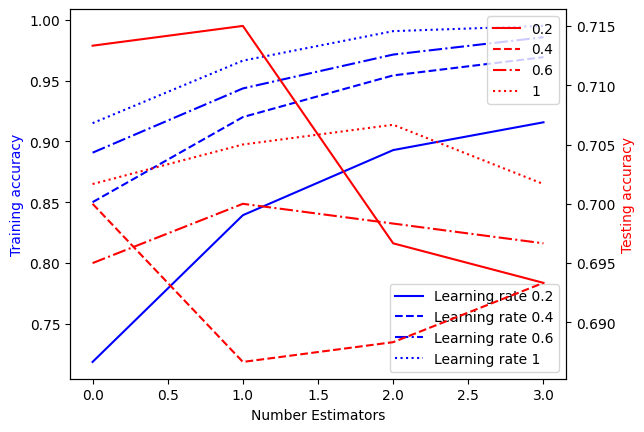

In [21]:
get_accuracy_boost(X,y,title="Training and Test Accuracy vs Weak Classifiers",times=10,xlabel='Number Estimators', n_est = 10)

### Evaluation Metric on Second Dataset


We can input a  `eval_metric`  parameter  in the `fit` method; this  determines how the model performs on each iteration using a second dataset; in XG Boost the metrics include:


`logloss` : binary logarithmic loss

`mlogloss` cross entropy loss

`error` : number of misclassified samples

`auc` : area under  ROC curve (receiver operating characteristic curve)

We will use `error`:


In [22]:
eval_metric="error"

The validation data must be a list `eval_set`: the list  contains a tuple, the first element of the tuple must be the features, the second must be the labels:


In [23]:
eval_set = [(X_test, y_test)]

When we fit the model, we input all the Hyperparameter   we set  `verbose=True` to display the results for each epoch.


In [24]:
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.23333
[1]	validation_0-error:0.18333
[2]	validation_0-error:0.21667
[3]	validation_0-error:0.18333
[4]	validation_0-error:0.18333
[5]	validation_0-error:0.21667
[6]	validation_0-error:0.20000
[7]	validation_0-error:0.20000
[8]	validation_0-error:0.20000
[9]	validation_0-error:0.20000
[10]	validation_0-error:0.21667
[11]	validation_0-error:0.20000
[12]	validation_0-error:0.20000
[13]	validation_0-error:0.21667
[14]	validation_0-error:0.21667
[15]	validation_0-error:0.21667
[16]	validation_0-error:0.21667
[17]	validation_0-error:0.25000
[18]	validation_0-error:0.25000
[19]	validation_0-error:0.23333
[20]	validation_0-error:0.23333
[21]	validation_0-error:0.25000
[22]	validation_0-error:0.25000
[23]	validation_0-error:0.25000
[24]	validation_0-error:0.23333
[25]	validation_0-error:0.23333
[26]	validation_0-error:0.25000
[27]	validation_0-error:0.23333
[28]	validation_0-error:0.25000
[29]	validation_0-error:0.25000
[30]	validation_0-error:0.25000
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

We can obtain the result for each iteration as a Python `dict` .`validation_0` is the label for dataset we input; this contains a nested dictionary. The nested dictionary's key is the type of metric; the values is a list that includes the value of the metric used for each epoch.


In [25]:
results = model.evals_result()
print(results)

{'validation_0': OrderedDict({'error': [0.23333333333333334, 0.18333333333333332, 0.21666666666666667, 0.18333333333333332, 0.18333333333333332, 0.21666666666666667, 0.2, 0.2, 0.2, 0.2, 0.21666666666666667, 0.2, 0.2, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.25, 0.25, 0.23333333333333334, 0.23333333333333334, 0.25, 0.25, 0.25, 0.23333333333333334, 0.23333333333333334, 0.25, 0.23333333333333334, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.23333333333333334, 0.25, 0.25, 0.25, 0.23333333333333334, 0.25, 0.23333333333333334, 0.25, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.25, 0.25, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.23333333333333334, 0.25, 0.23333333333333334, 0.25, 0.25, 0.25, 0.25, 0.25, 0.23333333333333334, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.23333333333333334, 0.23333333333333334, 0.2333333333333

We can plot the results for each epoch, we see the test error increases.


Text(0, 0.5, 'Misclassified Samples')

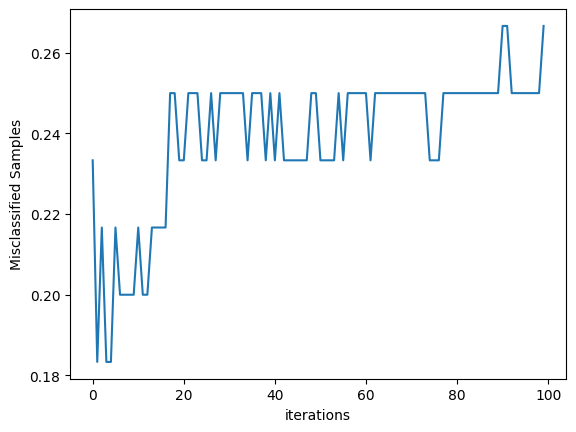

In [26]:
plt.plot(range(0, len(results['validation_0']['error'])), results['validation_0']['error'])
plt.xlabel('iterations')
plt.ylabel('Misclassified Samples')

We can input multiple datasets, for example we can input the training and test data and use the metric `logloss`.


In [27]:
eval_metric='logloss'
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set,verbose=False)
results=model.evals_result()

The dict  contains two elements the loss for the training and testing data, we display  the keys :


In [28]:
results.keys()

dict_keys(['validation_0', 'validation_1'])

We can plot the error here for each epoch.


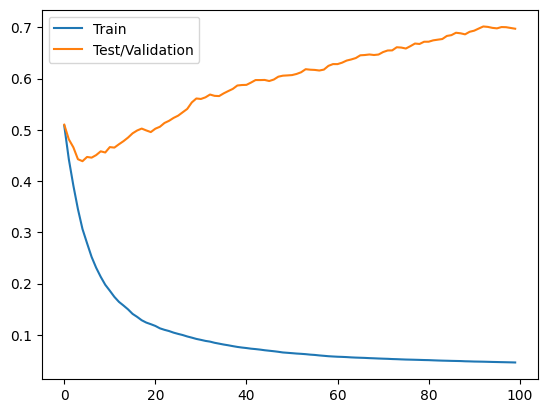

In [29]:
fig, ax = plt.subplots()
ax.plot( results['validation_0']['logloss'], label='Train')
ax.plot( results['validation_1']['logloss'], label='Test/Validation')
ax.legend()
plt.show()

We see that the training error decreases for each epoch in blue, but the validation error flattens then increases; this is a sign of overfitting. We can reduce this by early stopping.


#### Early Stopping


Early Stopping is a way to prevent overfitting; we stop gradient descent based on a specified number of epochs over which no improvement is observed using the evaluation set . The input parameter is  `early_stopping_rounds`.


In [30]:
early_stopping_rounds=10

We train the model:


In [31]:
eval_set = [(X_test, y_test)]
eval_metric='logloss'
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True,early_stopping_rounds=early_stopping_rounds)

[0]	validation_0-logloss:0.51017
[1]	validation_0-logloss:0.48158
[2]	validation_0-logloss:0.46597
[3]	validation_0-logloss:0.44277
[4]	validation_0-logloss:0.43894
[5]	validation_0-logloss:0.44720
[6]	validation_0-logloss:0.44586
[7]	validation_0-logloss:0.45081
[8]	validation_0-logloss:0.45817
[9]	validation_0-logloss:0.45591
[10]	validation_0-logloss:0.46643
[11]	validation_0-logloss:0.46546
[12]	validation_0-logloss:0.47197
[13]	validation_0-logloss:0.47800
[14]	validation_0-logloss:0.48500


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

We see the model does better for the same Hyperparamters values.


In [32]:
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.8166666666666667, 'train Accuracy': 0.9214285714285714}


## Parameters for Trees


We can also change tree parameters, consider our first example:


In [33]:
objective='binary:logistic'
learning_rate=0.1
n_estimators=10
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators,eval_metric='mlogloss')
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.8, 'train Accuracy': 0.85}


`max_depth` is the maximum depth of a tree. Increasing this value will make overfitting more likely, do decreasing max depth will decrease overfitting:


In [34]:
max_depth=3

In [35]:
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators,eval_metric='mlogloss',max_depth=max_depth)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7666666666666667, 'train Accuracy': 0.8071428571428572}


`min_child_weight` is essentially the minimum number of instances needed to be in each node,  larger values decrease overfitting. the default is one; setting it to four  we get better results on the training data.


In [36]:
min_child_weight=4

In [37]:
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators,eval_metric='mlogloss',min_child_weight=4)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7833333333333333, 'train Accuracy': 0.7928571428571428}


`gamma`, `reg_lambda` , `alpha` are other regularization parameters with default parameters of 0, 1 and 0, respectively. Increasing these parameters, will decrease overfitting.


In [38]:
gamma=1
reg_lambda=2
alpha=1
model =XGBClassifier(objective=objective,learning_rate=learning_rate,n_estimators=n_estimators,eval_metric='mlogloss',gamma=gamma,reg_lambda=reg_lambda,alpha=alpha)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test,  model))

{'test Accuracy': 0.7833333333333333, 'train Accuracy': 0.7785714285714286}
